In [6]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [36]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.expand_dims(img, axis=0)
    return img

In [13]:
content_path = 'content_image.jpg'
style_path = 'style_image.jpg'

In [33]:
def show_img(img, title):
    if len(img.shape) > 3:
        img = tf.squeeze(img, axis=0)

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

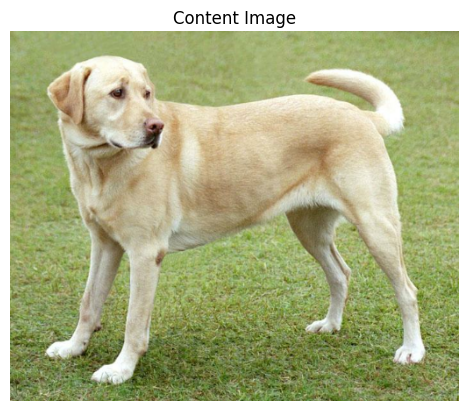

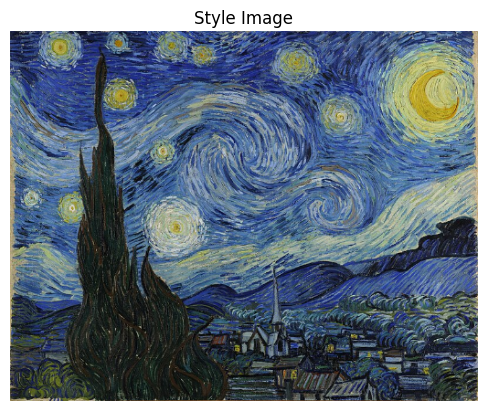

In [35]:
content_image = load_img(content_path)
style_image = load_img(style_path)

show_img(content_image, 'Content Image')
show_img(style_image, 'Style Image')